In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


In [2]:

# Read AAPL.csv containing open, high, low, close, Adj close, Volume of Apple stock with Twitter polarity scores and Twitter volume
df = pd.read_csv('AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)

# Calculate percentage change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values again
df.dropna(inplace=True)

df.head()




/tmp/ipykernel_10877/1229325645.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)


,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume,Pct_change
Date,,,,,,,,,
2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0,-0.024959
2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0,-0.019723
2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0,-0.041952
2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0,0.005362
2016-01-11,24.74,24.76,24.33,24.63,22.86,198957600,0.019443,1222.0,0.016000


In [3]:
# Print information about each column data type and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 921 entries, 2016-01-05 to 2019-08-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            921 non-null    float64
 1   High            921 non-null    float64
 2   Low             921 non-null    float64
 3   Close           921 non-null    float64
 4   Adj Close       921 non-null    float64
 5   Volume          921 non-null    int64  
 6   ts_polarity     921 non-null    float64
 7   twitter_volume  921 non-null    float64
 8   Pct_change      921 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 72.0 KB


In [4]:

# Define a cost matrix
cost_m = [[0, 3],  # Cost of false negative (predicting a decrease while it actually increases)
          [5, 0]]  # Cost of false positive (predicting an increase while it actually decreases)

# Convert target variable to binary based on percentage change
df['Target'] = np.where(df['Pct_change'] > 0, 1, 0)

df.head()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume,Pct_change,Target
Date,,,,,,,,,,
2016-01-05,26.44,26.46,25.60,25.68,23.83,223164000,0.133635,1430.0,-0.024959,0
2016-01-06,25.14,25.59,24.97,25.17,23.36,273829600,0.072042,1949.0,-0.019723,0
2016-01-07,24.67,25.03,24.11,24.11,22.38,324377600,0.074369,2289.0,-0.041952,0
2016-01-08,24.64,24.78,24.19,24.24,22.50,283192000,0.051595,2235.0,0.005362,1
2016-01-11,24.74,24.76,24.33,24.63,22.86,198957600,0.019443,1222.0,0.016000,1


In [5]:

# Define features and target variable
X = df.drop(columns=['Pct_change', 'Target'])  # Features
y = df['Target']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:

# Classifiers to be used
names = ['Random Forest', 'Naive Bayes']
classifiers = [RandomForestClassifier(n_estimators=100, random_state=0),
               GaussianNB()]

# Target names for classification report
target_names = ['Decrease', 'Increase']

# Iterate over classifiers
for name, clf in zip(names, classifiers):
    print(name)
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Predict probabilities
    y_pred_prob = clf.predict_proba(X_test)
    
    # Calculate predicted labels with cost minimization
    y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
    
    # Print classification report
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Print confusion matrix
    conf_m = confusion_matrix(y_test, y_pred).T
    print(conf_m)
    
    # Calculate total cost
    print("Total Cost:", np.sum(conf_m * cost_m))
    print()


Random Forest
              precision    recall  f1-score   support

    Decrease       0.46      0.78      0.58        82
    Increase       0.61      0.27      0.38       103

    accuracy                           0.50       185
   macro avg       0.53      0.53      0.48       185
weighted avg       0.54      0.50      0.47       185

[[64 75]
 [18 28]]
Total Cost: 315

Naive Bayes
              precision    recall  f1-score   support

    Decrease       0.44      1.00      0.61        82
    Increase       0.00      0.00      0.00       103

    accuracy                           0.44       185
   macro avg       0.22      0.50      0.31       185
weighted avg       0.20      0.44      0.27       185

[[ 82 103]
 [  0   0]]
Total Cost: 309



/home/nikos/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nikos/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nikos/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipykernel_5879/1520157312.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
              precision    recall  f1-score   support

    Decrease       0.98      1.00      0.99        82
    Increase       1.00      0.98      0.99       103

    accuracy                           0.99       185
   macro avg       0.99      0.99      0.99       185
weighted avg       0.99      0.99      0.99       185

[[ 82   2]
 [  0 101]]
Total Cost: 6


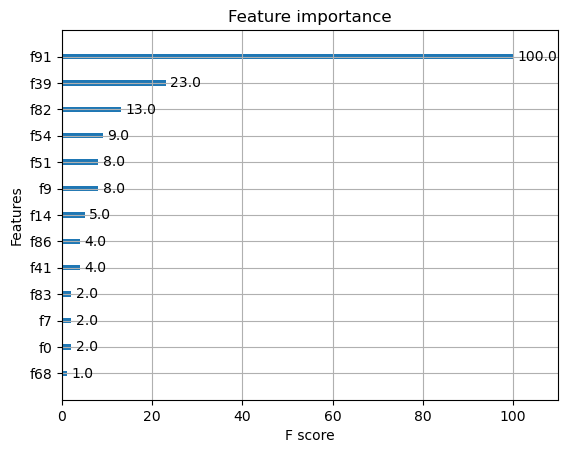

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from ta import add_all_ta_features
from ta.utils import dropna

# Read AAPL.csv containing open, high, low, close, Adj close, Volume of Apple stock with Twitter polarity scores and Twitter volume
df = pd.read_csv('AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)

# Calculate percentage change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values again
df.dropna(inplace=True)

# Add technical indicators
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)

# Convert target variable to binary based on percentage change
df['Target'] = np.where(df['Pct_change'] > 0, 1, 0)

# Drop percentage change column
df.drop(columns=['Pct_change'], inplace=True)

# Define features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define cost matrix
cost_m = [[0, 3],  # Cost of false negative
          [5, 0]]  # Cost of false positive

# XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning with cross-validation
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_

# Predict probabilities
y_pred_prob = best_model.predict_proba(X_test)

# Calculate predicted labels with cost minimization
y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Decrease', 'Increase']))

# Print confusion matrix
conf_m = confusion_matrix(y_test, y_pred).T
print(conf_m)

# Calculate total cost
total_cost = np.sum(conf_m * cost_m)
print("Total Cost:", total_cost)

# Feature importance
xgb.plot_importance(best_model)
plt.show()
